# 계류 법안 분석 

작성자: 박하람

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
bill_df = pd.read_csv('bill_20th_data_final.csv', parse_dates=['제안일자','의결일자'])
bill_df = bill_df[['의안번호','의안명','제안자구분','제안일자','의결일자','의결결과','제안회기','제안이유','소관위원회','법률반영여부']]

In [3]:
bill_df.shape

(23684, 10)

In [4]:
bill_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23684 entries, 0 to 23683
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   의안번호    23684 non-null  int64         
 1   의안명     23684 non-null  object        
 2   제안자구분   23684 non-null  object        
 3   제안일자    23684 non-null  datetime64[ns]
 4   의결일자    23684 non-null  datetime64[ns]
 5   의결결과    23684 non-null  object        
 6   제안회기    23684 non-null  object        
 7   제안이유    23016 non-null  object        
 8   소관위원회   23454 non-null  object        
 9   법률반영여부  23684 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(7)
memory usage: 1.8+ MB


In [5]:
# NaN 채우기 
bill_df = bill_df.fillna('')
bill_df.isnull().sum()

의안번호      0
의안명       0
제안자구분     0
제안일자      0
의결일자      0
의결결과      0
제안회기      0
제안이유      0
소관위원회     0
법률반영여부    0
dtype: int64

## 데이터 전처리 

- 법률안만 선정

> 의안의 결과를 예측하기 위해서는 먼저 문제의 특성을 잘 이해하는 것이 중요하다. 먼저 의안에는 기존 법률을 수정, 폐지하거나 새로운 법률을 제안하는 법률안만 있는 것이 아니라 결의안, 동의안, 출석요구안, 예산안, 정부 관리직의 임명선출안 등도 포함된다. 그 중에서 일반 시민 및 각종 이익 단체에 영향을 가장 크게 주는 것은 법을 수정하는 법률안이므로, 이 연구에서는 법률안에 중점을 둔다.(선행연구)

#### 법률안 추리기

In [6]:
def split_name(x): 
    name = x.split('(')[0]
    return name

def preprocessing(text):
    # 특수문자 제거
    text = re.sub('[?.,;:|\)(*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    return text

In [7]:
bill_df['의안명'] = bill_df['의안명'].apply(lambda x: split_name(x))

In [8]:
bill_df.loc[bill_df['의안명'].str.endswith('법률안') == True, '법률안'] = 1
bill_df.loc[bill_df['의안명'].str.endswith('법률안') == False, '법률안'] = 0

In [9]:
bill_df['법률안'].value_counts()

1.0    22453
0.0     1231
Name: 법률안, dtype: int64

In [10]:
bill_df = bill_df[bill_df['법률안'] == 1]

In [11]:
len(bill_df)

22453

#### 의안명, 제안이유 클렌징

In [12]:
%time bill_df['의안명'] = bill_df['의안명'].apply(lambda x: preprocessing(x))
%time bill_df['제안이유'] = bill_df['제안이유'].apply(lambda x: preprocessing(x))

CPU times: user 68.5 ms, sys: 0 ns, total: 68.5 ms
Wall time: 70.1 ms
CPU times: user 932 ms, sys: 7.95 ms, total: 940 ms
Wall time: 942 ms


## EDA 

### 법률 반영/미반영 기준으로 의안처리시 소요시간 분석

- 법률반영: 원안가결, 원안수정, 대안반영, 수정안반영
- 법률미반영: 부결, 폐기, 철회, 반려, 기타 

In [13]:
bill_df['의결결과'].unique()

array(['임기만료폐기', '원안가결', '수정가결', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기'],
      dtype=object)

- accept_list = ['대안반영폐기', '원안가결', '수정가결', '수정안반영폐기', '가결']
- reject_list = ['임기만료폐기', '부결', '철회', '반려', '심사대상제외', '폐기']

In [14]:
bill_tmp = bill_df['의결결과'].value_counts()
bill_tmp

임기만료폐기     14269
대안반영폐기      5003
원안가결        1964
수정가결         852
철회           201
폐기           121
수정안반영폐기       41
부결             2
Name: 의결결과, dtype: int64

In [15]:
bill_df['법률반영여부'].value_counts()

미반영    14593
반영      7860
Name: 법률반영여부, dtype: int64

In [16]:
bill_df['의결처리기간'] = (bill_df['의결일자'] - bill_df['제안일자']).dt.days
bill_df.head(3)

,의안번호,의안명,제안자구분,제안일자,의결일자,의결결과,제안회기,제안이유,소관위원회,법률반영여부,법률안,의결처리기간
0,2024996,집합건물의 소유 및 관리에 관한 법률 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,아파트 등 공동주택은 공동주택관리법 에 의해 체계적으로 관리되고 있는 반면 ...,법제사법위원회,미반영,1.0,7
1,2024995,지방세법 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,현행법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 부동산 가격...,행정안전위원회,미반영,1.0,7
2,2024994,법률용어 정비를 위한 정보위원회 소관 개 법률 일부개정을 위한 법률안,위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,,정보위원회,반영,1.0,0


In [17]:
bill_df['의결처리기간'].groupby(bill_df['법률반영여부']).mean()

법률반영여부
미반영    759.561228
반영     253.647837
Name: 의결처리기간, dtype: float64

In [18]:
pend_df = pd.pivot_table(bill_df, 
                        index=['법률반영여부', '의결결과'],
                        values=['의결처리기간']).fillna(0)
pend_df

의결처리기간
법률반영여부 의결결과               
미반영    부결       217.500000
       임기만료폐기   772.238419
       철회        83.865672
       폐기       395.991736
반영     대안반영폐기   321.562063
       수정가결     283.303991
       수정안반영폐기  207.975610
       원안가결      68.734725

In [19]:
# 의결처리기간 - 평균 
pd.merge(pend_df, bill_tmp, left_on='의결결과', right_index=True)

의결처리기간   의결결과
법률반영여부 의결결과                      
미반영    부결       217.500000      2
       임기만료폐기   772.238419  14269
       철회        83.865672    201
       폐기       395.991736    121
반영     대안반영폐기   321.562063   5003
       수정가결     283.303991    852
       수정안반영폐기  207.975610     41
       원안가결      68.734725   1964

In [20]:
print('미반영 평균 소요시간: ', pend_df.loc['미반영','의결처리기간'].mean())
print('반영 평균 소요시간: ', pend_df.loc['반영','의결처리기간'].mean())

미반영 평균 소요시간:  367.3989565322882
반영 평균 소요시간:  220.39409704492132


#### 소관위원회별 법률반영여부 분석

법률반영여부에 대한 기준은 의안정보시스템에 따른 것. 그러나 대안반영폐기, 수정안반영폐기는 법률안이 되지 못하므로 이것이 과연 법률이 반영 되었다 볼 수 있는가의 문제도 존재. 

> 일반적으로 법률안들은 임기만료폐기, 대안반영폐기, 폐기, 철회, 부결, 공포 등 6가지 상태 중 하나로 끝나게 된다. 그 중에서 공포된 법률안만이 성공적으로 “통과”되었다고 볼 수 있으며, 공포 단계에 이르기 전에 현재 국회의 임기가 만료되거나(임기만료폐기), 같은 목적을 가진 다른 대안이 반영되어 원안이 폐 기되거나(대안반영폐기), 발의한 의원들이 철회를 하는 경우 법률안은 법이 되지 못한다. 본 연구에서는 법률안의 발의 시점, 즉 접수 단계에서 해당 법률안이 공포될 것인지의 여부를 예측하는 것을 목표로 한다. (선행연구) 

### 법률공포여부 분석

In [21]:
comm_df = bill_df.copy()

In [22]:
proclaim_list = ['원안가결', '수정가결']
reject_list = ['임기만료폐기', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기']

In [23]:
comm_df.loc[comm_df['의결결과'].isin(proclaim_list), '법률공포여부'] = '공포'
comm_df.loc[comm_df['의결결과'].isin(reject_list), '법률공포여부'] = '미공포'

In [24]:
# 기타 index 번호: 9443, 10301, 10508 (소관위원회 없는 경우)
comm_df[comm_df['소관위원회'] == '']
comm_df.drop([9443, 10301, 10508],inplace=True)

In [25]:
comm_df['법률공포여부'].value_counts()

미공포    19634
공포      2816
Name: 법률공포여부, dtype: int64

#### 소관위원회별 법률공포여부 분석

국회법 제4장 회의 제2절 발의, 동의, 철회와 번안 

> 제33조 3번 의안이 발의 또는 제출되었을 때에는 의장은 이것을 국회에 보고한 후 적당한 위원회에 부탁하고 그 심사가 끝난 뒤에 본회의에 부의한다. **단, 법률안 이외의 의안은 국회의 결의에 의하여 위원회의 심사를 생략할 수 있다.**

**적어도 100개 이상**의 데이터가 있는 것으로 분석해야

In [26]:
comm = comm_df['소관위원회'].unique()
special_comm = [com for com in comm if com.endswith('특별위원회') == True]
basic_comm = [com for com in comm if com.endswith('특별위원회') == False]

print('상설 특별위원회 리스트:', '\n', special_comm, '\n')
print('상임위원회 리스트:', '\n', basic_comm)

상설 특별위원회 리스트: 
 ['헌법개정 및 정치개혁 특별위원회', '정치개혁 특별위원회', '사법개혁 특별위원회'] 

상임위원회 리스트: 
 ['법제사법위원회', '행정안전위원회', '정보위원회', '여성가족위원회', '문화체육관광위원회', '국회운영위원회', '과학기술정보방송통신위원회', '기획재정위원회', '국토교통위원회', '환경노동위원회', '외교통일위원회', '농림축산식품해양수산위원회', '정무위원회', '국방위원회', '교육위원회', '보건복지위원회', '산업통상자원중소벤처기업위원회', '교육문화체육관광위원회', '안전행정위원회', '산업통상자원위원회', '미래창조과학방송통신위원회']


In [27]:
comm_df.loc[comm_df['소관위원회'].isin(basic_comm), '위원회 분류'] = '상임위원회'
comm_df.loc[comm_df['소관위원회'].isin(special_comm), '위원회 분류'] = '특별위원회'

#### 상임위원회만 분석

In [28]:
comm_df1 = comm_df[comm_df['위원회 분류'] == '상임위원회']
comm_df1.head()

,의안번호,의안명,제안자구분,제안일자,의결일자,의결결과,제안회기,제안이유,소관위원회,법률반영여부,법률안,의결처리기간,법률공포여부,위원회 분류
0,2024996,집합건물의 소유 및 관리에 관한 법률 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,아파트 등 공동주택은 공동주택관리법 에 의해 체계적으로 관리되고 있는 반면 ...,법제사법위원회,미반영,1.0,7,미공포,상임위원회
1,2024995,지방세법 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,현행법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 부동산 가격...,행정안전위원회,미반영,1.0,7,미공포,상임위원회
2,2024994,법률용어 정비를 위한 정보위원회 소관 개 법률 일부개정을 위한 법률안,위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,,정보위원회,반영,1.0,0,공포,상임위원회
3,2024993,진실 화해를 위한 과거사정리 기본법 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,,행정안전위원회,반영,1.0,0,공포,상임위원회
4,2024992,화재예방 소방시설 설치 유지 및 안전관리에 관한 법률 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,,행정안전위원회,반영,1.0,0,공포,상임위원회


In [29]:
comm_df2 = pd.DataFrame(comm_df1.groupby('소관위원회')['법률공포여부'].value_counts()).unstack().fillna(0)
comm_df2.reset_index(inplace=True)
comm_df2.columns = ['소관위원회','공포','미공포']
comm_df2.head()

,소관위원회,공포,미공포
0,과학기술정보방송통신위원회,111,855
1,교육문화체육관광위원회,109,124
2,교육위원회,91,796
3,국방위원회,58,424
4,국토교통위원회,385,1751


In [30]:
comm_df2['합계'] = comm_df2['공포'] + comm_df2['미공포']
comm_df2['공포율'] = np.round((comm_df2['공포'] / comm_df2['합계']) * 100)

# 9, 12번은 의안수가 100이하라는 것을 감안하면, 아래 100 이상 의안수는 의미 있다. 왜 이렇게 나올까? 
comm_df2.sort_values(by='공포율', ascending=False)

,소관위원회,공포,미공포,합계,공포율
9,미래창조과학방송통신위원회,7,4,11,64.0
12,산업통상자원위원회,58,38,96,60.0
1,교육문화체육관광위원회,109,124,233,47.0
7,농림축산식품해양수산위원회,446,1158,1604,28.0
14,안전행정위원회,33,109,142,23.0
4,국토교통위원회,385,1751,2136,18.0
15,여성가족위원회,65,325,390,17.0
13,산업통상자원중소벤처기업위원회,199,998,1197,17.0
11,보건복지위원회,314,2158,2472,13.0
3,국방위원회,58,424,482,12.0


In [31]:
# 국회의원들의 관심도를 드러내는 것이 맞을까? 이렇게 많이 발의했다면? 
comm_df2.sort_values(by='합계', ascending=False)

,소관위원회,공포,미공포,합계,공포율
19,행정안전위원회,162,2502,2664,6.0
11,보건복지위원회,314,2158,2472,13.0
4,국토교통위원회,385,1751,2136,18.0
6,기획재정위원회,114,1902,2016,6.0
20,환경노동위원회,177,1791,1968,9.0
10,법제사법위원회,151,1667,1818,8.0
7,농림축산식품해양수산위원회,446,1158,1604,28.0
17,정무위원회,184,1385,1569,12.0
13,산업통상자원중소벤처기업위원회,199,998,1197,17.0
0,과학기술정보방송통신위원회,111,855,966,11.0


## 소관위원회별 토픽 모델링 



In [32]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk-13.0.2"
!pip3 install nltk

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic/main a

In [33]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 60 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 145083 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [34]:
comm_df.loc[comm_df['소관위원회'].isin(basic_comm), '위원회 분류'] = '상임위원회'
comm_df.loc[comm_df['소관위원회'].isin(special_comm), '위원회 분류'] = '특별위원회'

### 상임위원회 분석

In [35]:
comm_df1 = comm_df[comm_df['위원회 분류'] == '상임위원회']
comm_df1.head(3)

,의안번호,의안명,제안자구분,제안일자,의결일자,의결결과,제안회기,제안이유,소관위원회,법률반영여부,법률안,의결처리기간,법률공포여부,위원회 분류
0,2024996,집합건물의 소유 및 관리에 관한 법률 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,아파트 등 공동주택은 공동주택관리법 에 의해 체계적으로 관리되고 있는 반면 ...,법제사법위원회,미반영,1.0,7,미공포,상임위원회
1,2024995,지방세법 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,현행법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 부동산 가격...,행정안전위원회,미반영,1.0,7,미공포,상임위원회
2,2024994,법률용어 정비를 위한 정보위원회 소관 개 법률 일부개정을 위한 법률안,위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,,정보위원회,반영,1.0,0,공포,상임위원회


In [36]:
comm_df1['소관위원회'].value_counts()

행정안전위원회            2664
보건복지위원회            2472
국토교통위원회            2136
기획재정위원회            2016
환경노동위원회            1968
법제사법위원회            1818
농림축산식품해양수산위원회      1604
정무위원회              1569
산업통상자원중소벤처기업위원회    1197
과학기술정보방송통신위원회       966
교육위원회               887
문화체육관광위원회           745
국회운영위원회             515
국방위원회               482
여성가족위원회             390
외교통일위원회             284
교육문화체육관광위원회         233
안전행정위원회             142
산업통상자원위원회            96
정보위원회                31
미래창조과학방송통신위원회        11
Name: 소관위원회, dtype: int64

In [37]:
comm_df1['의안명+제안이유'] = (comm_df1['의안명'] + ' ' + comm_df1['제안이유']).str.strip()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
comm_anal1 = comm_df1[['소관위원회','의결결과','법률공포여부','의결처리기간','의안명+제안이유']]

for index, com in enumerate(basic_comm): 
    print(index, com)

0 법제사법위원회
1 행정안전위원회
2 정보위원회
3 여성가족위원회
4 문화체육관광위원회
5 국회운영위원회
6 과학기술정보방송통신위원회
7 기획재정위원회
8 국토교통위원회
9 환경노동위원회
10 외교통일위원회
11 농림축산식품해양수산위원회
12 정무위원회
13 국방위원회
14 교육위원회
15 보건복지위원회
16 산업통상자원중소벤처기업위원회
17 교육문화체육관광위원회
18 안전행정위원회
19 산업통상자원위원회
20 미래창조과학방송통신위원회


#### [0] 법제사법위원회

법제사법위원회(法制司法委員會)는 법제·사법에 관한 국회의 의사결정기능을 실질적으로 수행하는 국회 상임위원회이다.

In [39]:
com1 = comm_anal1[comm_anal1['소관위원회'] == basic_comm[0]]
com1.shape

(1818, 5)

In [40]:
com1['법률공포여부'].value_counts()

미공포    1667
공포      151
Name: 법률공포여부, dtype: int64

In [41]:
# 공포/미공포 분류
com1_pro = com1[com1['법률공포여부'] == '공포'].reset_index()
com1_unpro = com1[com1['법률공포여부'] == '미공포'].reset_index()

In [42]:
com1_pro.head(3)

,index,소관위원회,의결결과,법률공포여부,의결처리기간,의안명+제안이유
0,59,법제사법위원회,원안가결,공포,0,군사법원법 일부개정법률안 군인 군무원 등 사이에 발생한 범죄의 피해자에게 변호사가 ...
1,61,법제사법위원회,원안가결,공포,0,출입국관리법 일부개정법률안 가 출입국 전 과정에서 지문 얼굴을 비롯하여 홍채 ...
2,62,법제사법위원회,원안가결,공포,0,주택임대차보호법 일부개정법률안 현행법은 임대인은 임대차기간 종료 개월 전부터 개월 ...


In [83]:
import nltk 
from konlpy.tag import Okt

okt = Okt()

In [161]:
# 한글 전처리
def preprocessing(text): 
  text = re.sub('\\\\n', ' ', text)
  text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
  return text

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근',
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄'
              '중','게','너무','자','이런','때','되지','위해','에는','없는',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
             '마련','있도록','또는','함','하도록','개월','부터','제호','관','되고','년','월','및','등','안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [142]:
%time contents = com1_pro['의안명+제안이유'].apply(preprocessing)

CPU times: user 9.75 ms, sys: 1.05 ms, total: 10.8 ms
Wall time: 10.7 ms


In [143]:
%time tokens = contents.apply(okt.nouns)
tokens[:3]

CPU times: user 7.21 s, sys: 59.1 ms, total: 7.27 s
Wall time: 6.27 s


0    [군사법원, 법, 일부, 개정, 법률, 안, 군인, 군무원, 등, 사이, 발생, 범...
1    [출입국관리법, 일부, 개정, 법률, 안, 출입국, 전, 과정, 지문, 얼굴, 비롯...
2    [주택임대차보호법, 일부, 개정, 법률, 안, 현행법, 임대, 임대차, 기간, 종료...
Name: 의안명+제안이유, dtype: object

In [144]:
# 불용어 처리 
%time tokens_clean = tokens.apply(remove_stopword)
tokens_clean[:3]

CPU times: user 32.2 ms, sys: 5 µs, total: 32.2 ms
Wall time: 32 ms


0    [군사법원, 법, 개정, 법률, 군인, 군무원, 발생, 범죄, 피해자, 변호사, 군...
1    [출입국관리법, 개정, 법률, 출입국, 과정, 지문, 얼굴, 비롯, 홍채, 손바닥,...
2    [주택임대차보호법, 개정, 법률, 현행법, 임대, 임대차, 종료, 임차, 상대방, ...
Name: 의안명+제안이유, dtype: object

In [145]:
# word2vec 모델 학습에 로그를 찍을 수 있도록 합니다.
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [146]:
# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(tokens_clean, size=100, window=2, workers=4, min_count=10, iter=30, sg=1)

model

2020-08-29 04:49:15,535 : INFO : collecting all words and their counts
2020-08-29 04:49:15,536 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-29 04:49:15,544 : INFO : collected 2566 word types from a corpus of 18263 raw words and 151 sentences
2020-08-29 04:49:15,545 : INFO : Loading a fresh vocabulary
2020-08-29 04:49:15,551 : INFO : effective_min_count=10 retains 424 unique words (16% of original 2566, drops 2142)
2020-08-29 04:49:15,554 : INFO : effective_min_count=10 leaves 12619 word corpus (69% of original 18263, drops 5644)
2020-08-29 04:49:15,558 : INFO : deleting the raw counts dictionary of 2566 items
2020-08-29 04:49:15,560 : INFO : sample=0.001 downsamples 108 most-common words
2020-08-29 04:49:15,561 : INFO : downsampling leaves estimated 9743 word corpus (77.2% of prior 12619)
2020-08-29 04:49:15,564 : INFO : estimated required memory for 424 words and 100 dimensions: 551200 bytes
2020-08-29 04:49:15,566 : INFO : resetting layer weights

In [147]:
# 모델 이름을 지정하고 저장한다.
model_name = '1minwords'
model.save(model_name)

2020-08-29 04:49:21,902 : INFO : saving Word2Vec object under 1minwords, separately None
2020-08-29 04:49:21,903 : INFO : not storing attribute vectors_norm
2020-08-29 04:49:21,904 : INFO : not storing attribute cum_table
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-08-29 04:49:21,923 : INFO : saved 1minwords


In [148]:
len(model.wv.vocab)

424

In [149]:
# 단어 사전에서 상위 30개만 보기
vocab = model.wv.vocab
sorted(vocab, key=vocab.get, reverse=True)[:30]

['법률',
 '제조',
 '개정',
 '규정',
 '범죄',
 '법',
 '신설',
 '국가',
 '절차',
 '위원회',
 '처벌',
 '보호관찰',
 '최고',
 '제도',
 '보호',
 '사건',
 '결정',
 '회의',
 '폐지',
 '공무원',
 '법원',
 '내용',
 '사항',
 '사람',
 '행위',
 '재건',
 '제정',
 '현행법',
 '명령',
 '허가']

In [98]:
# 자주 등장하는 단어 찾기 
from collections import Counter 
dict(Counter(vocab).most_common(20))

{'개정': <gensim.models.keyedvectors.Vocab at 0x7f9be3061d30>,
 '결정': <gensim.models.keyedvectors.Vocab at 0x7f9be304f128>,
 '공무원': <gensim.models.keyedvectors.Vocab at 0x7f9be30430f0>,
 '국가': <gensim.models.keyedvectors.Vocab at 0x7f9be2ff60f0>,
 '규정': <gensim.models.keyedvectors.Vocab at 0x7f9be304f9e8>,
 '범죄': <gensim.models.keyedvectors.Vocab at 0x7f9be3061f98>,
 '법': <gensim.models.keyedvectors.Vocab at 0x7f9be3061c88>,
 '법률': <gensim.models.keyedvectors.Vocab at 0x7f9be3061da0>,
 '보호': <gensim.models.keyedvectors.Vocab at 0x7f9be3056860>,
 '보호관찰': <gensim.models.keyedvectors.Vocab at 0x7f9be3025630>,
 '사건': <gensim.models.keyedvectors.Vocab at 0x7f9be30569b0>,
 '신설': <gensim.models.keyedvectors.Vocab at 0x7f9be3056908>,
 '위원회': <gensim.models.keyedvectors.Vocab at 0x7f9be3043cf8>,
 '절차': <gensim.models.keyedvectors.Vocab at 0x7f9be3056240>,
 '제도': <gensim.models.keyedvectors.Vocab at 0x7f9be3056668>,
 '제조': <gensim.models.keyedvectors.Vocab at 0x7f9be304f390>,
 '처벌': <gensim.models

In [99]:
# 가장 적게 등장하는 단어
min(vocab, key=vocab.get)

'증인'

In [72]:
model.wv['군인']

array([-0.04178247,  0.00995527,  0.01127228, -0.0237278 ,  0.01766042,
       -0.01801175,  0.04910222, -0.02633392, -0.03334568,  0.01347004,
       -0.00909449, -0.04288323,  0.02389501, -0.02705315,  0.01691377,
       -0.01094381, -0.01393488, -0.03607094,  0.02447291, -0.00368856,
       -0.01573619,  0.01413298,  0.01945139,  0.00209324, -0.03173568,
        0.00030645, -0.01690439, -0.01162331,  0.00216351,  0.06021504,
       -0.01452843,  0.01073301,  0.04382967, -0.04213186, -0.03940219,
        0.01847599, -0.03930755,  0.02458521, -0.00512442, -0.00549772,
        0.01527531,  0.04598435, -0.02858376, -0.01901114,  0.01857365,
       -0.01938391,  0.04476323, -0.01696218, -0.00136525, -0.01440254,
        0.0064194 ,  0.00061593, -0.04289783,  0.04375203, -0.02446989,
        0.01114993,  0.018478  , -0.01656773,  0.01717295, -0.01025794,
       -0.00753602,  0.0067621 ,  0.00831147, -0.03127437,  0.04757028,
        0.0227711 , -0.00578295,  0.00138998, -0.00822824,  0.00

In [164]:
model.wv.most_similar('박근혜')

KeyError: ignored

## K-means

In [113]:
from sklearn.cluster import KMeans 

word_vec = model.wv.syn0 # 어휘의 feature vector 
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
idx = kmeans.fit_predict(word_vec)

idx = list(idx)
names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [114]:
for c in range(num_clusters):
    # 클러스터 번호를 출력
    print("\ncluster {}".format(c))
    
    words = []
    cluster_values = list(word_centroid_map.values())
    for i in range(len(cluster_values)):
        if (cluster_values[i] == c):
            words.append(list(word_centroid_map.keys())[i])            
    print(words)


cluster 0
['통신비밀보호법', '입국신고서', '경보', '발령', '주택임대차보호법', '위원장', '사이버', '청원', '유사', '아동복지법', '질', '북부', '편집', '페이크', '예규', '회선', '수신', '전면', '불비', '상승', '인도', '수집', '독립성', '거목', '부합', '육군', '창설', '축산', '가운데', '한시법', '임제', '거리', '게기', '안심사', '검찰청', '가치', '방위', '근로자', '상속', '정도', '널리', '목욕실', '발', '한실', '탈의실', '진정', '문자', '본문', '공판', '조속', '반환', '집행정지', '공동체', '차지', '우리말', '세종', '특별시', '광역시', '공갈', '구치소', '거치', '사직', '결혼', '내지', '착용', '피치', '박근혜', '서원', '확립', '건축법', '증인', '복사', '성명', '불구속', '아래', '존중', '구속집행정지', '정황', '조력', '장안', '장함', '본형', '지문', '얼굴', '홍채', '손바닥', '정맥', '기반', '국경관리', '구축', '위기', '국민보호', '공공안전', '인적', '숙박', '공관', '과중', '짐', '승선', '정박', '휴양', '상륙', '상대방', '대차', '통상', '구', '자동', '보임', '각하', '수락', '정안', '텔레그램', '착취', '관심사', '고조', '홈페이지', '텔레', '그램', '번방', '계류', '미연', '중상', '도지사', '임시조치', '동거', '재학', '급박', '도달', '단위', '복지', '안대', '계양구', '서구', '강화군', '가정', '마산', '진주', '통영', '밀양', '거창', '인물', '소위', '국회사무처', '편차', '정성', '권유', '통고', '나이', '탄력성', '패킷', '선별', '송', '부하', '법규', '합', 

## 시각화

In [122]:
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib

path_gothic = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
prop = fm.FontProperties(fname=path_gothic)
matplotlib.rcParams["axes.unicode_minus"] = False

In [116]:
vocab = list(model.wv.vocab)
X = model[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [117]:
import pandas as pd

df = pd.DataFrame(X_tsne, index=vocab, columns=["x", "y"])

In [118]:
df.head()

,x,y
군사법원,22.221066,-22.041847
법,19.537352,-26.013407
개정,20.113605,-28.126966
법률,20.140749,-28.013054
군인,14.272548,-28.505373


In [123]:
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df["x"], df["y"])

for word, pos in list(df.iterrows()):
    ax.annotate(word, pos, fontsize=12, fontproperties=prop)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 단어 유사도 시각화

In [74]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '1minwords'
model = g.Doc2Vec.load(model_name)

2020-08-29 04:12:07,913 : INFO : loading Doc2Vec object from 1minwords
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-08-29 04:12:07,942 : INFO : loading wv recursively from 1minwords.wv.* with mmap=None
2020-08-29 04:12:07,943 : INFO : setting ignored attribute vectors_norm to None
2020-08-29 04:12:07,946 : INFO : loading vocabulary recursively from 1minwords.vocabulary.* with mmap=None
2020-08-29 04:12:07,949 : INFO : loading trainables recursively from 1minwords.trainables.* with mmap=None
2020-08-29 04:12:07,952 : INFO : setting ignored attribute cum_table to None
2020-08-29 04:12:07,954 : INFO : loaded 1minwords


In [75]:
# Doc2Vec으로 만든 모델을 가져옴
vocab = list(model.wv.vocab)
# 모델의 단어를 피처로 지정해 준다.
X = model[vocab]

print('Feature의 길이 {}'.format(len(X)))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 모든 단어를 그래프에 출력하면 글자가 너무 많이 겹치기 때문에 일부 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:150,:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


Feature의 길이 2567
[-0.021487    0.0071827   0.00572826 -0.01947056  0.00868756 -0.01298815
  0.03362343 -0.01319032 -0.01811677  0.00246113]


In [76]:
df = pd.DataFrame(X_tsne, index=vocab[:150], columns=['x', 'y'])
df.shape

(150, 2)

In [77]:
df.head(20)

,x,y
군사법원,1.592831,-0.878198
법,-8.224697,11.290627
개정,-8.033395,10.457949
법률,-8.478826,11.505531
군인,0.429435,0.488728
군무원,6.108180,-5.460221
사이,2.258203,-1.517114
발생,-6.419912,8.310845
범죄,-8.435052,11.165479
피해자,-2.768373,4.428372


In [120]:
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 나눔고딕 설치
!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

2020-08-29 04:12:11,396 : WARNING : findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
2020-08-29 04:12:11,720 : WARNING : findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44400 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50896 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214:

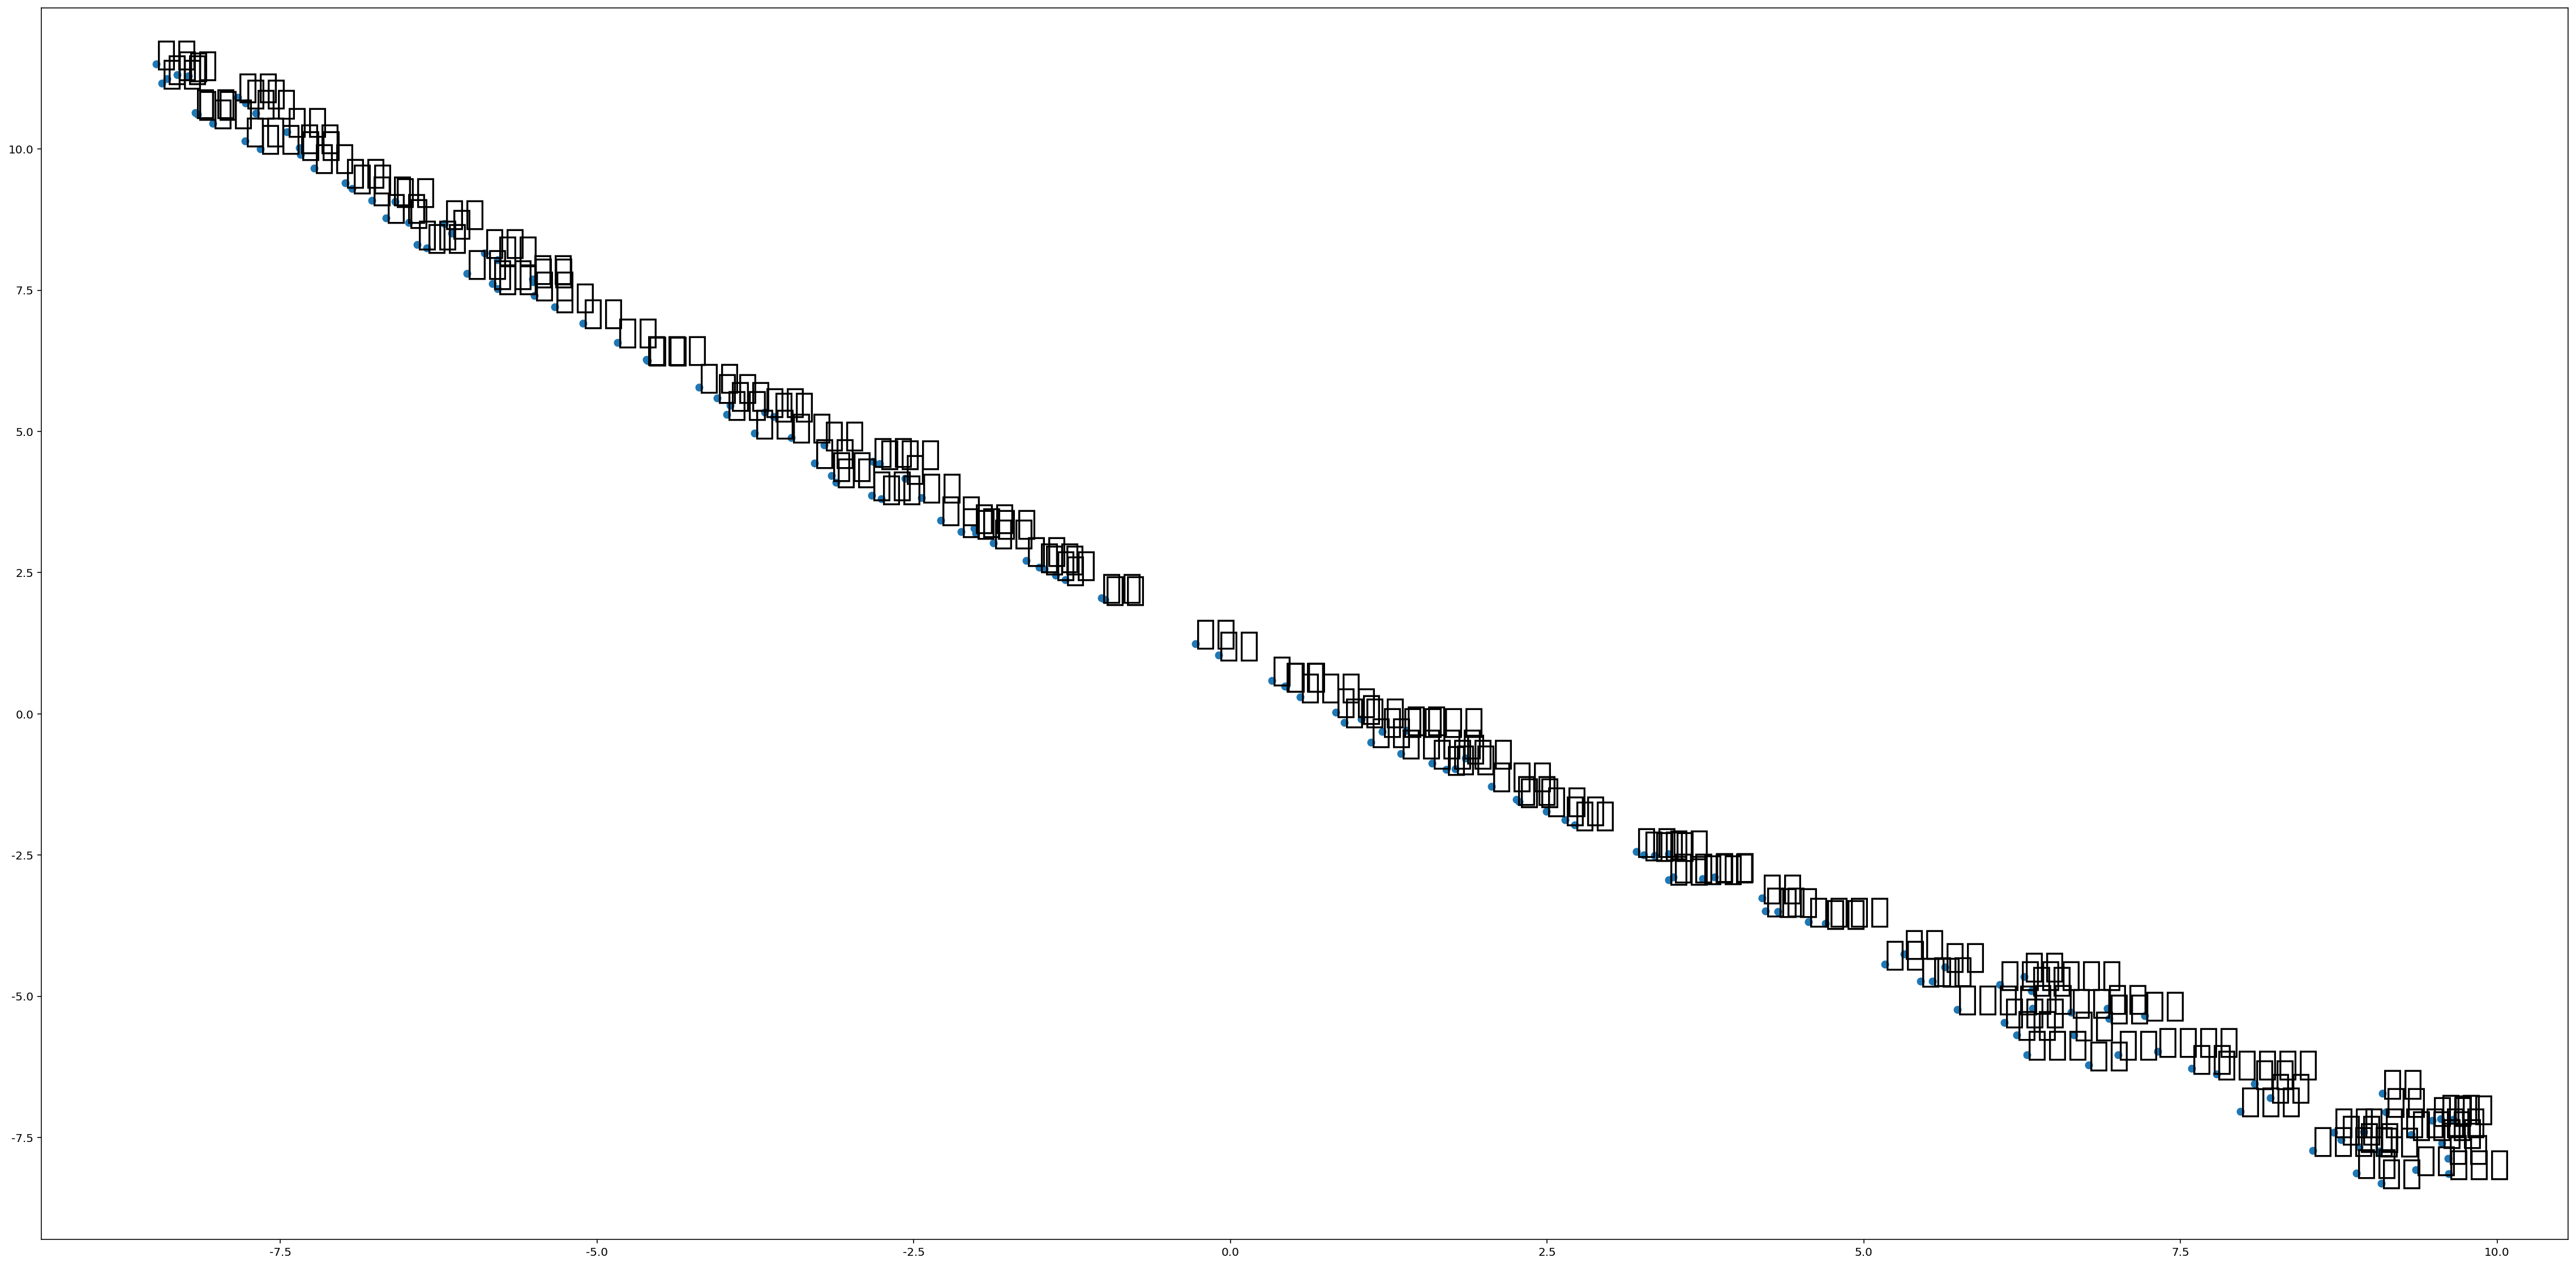

In [79]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()